In [1]:
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from dataloader import LandmarkDataset, SequenceDataset, LandmarkWaveletDataset
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

%load_ext autoreload
pd.set_option('mode.chained_assignment', None)
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
%autoreload 2

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

find landmark files

In [3]:
data_root = Path('/mnt/Storage1/Data/K7')

landmark_files = list(data_root.glob('2020-*/Down/model=*.h5'))
landmark_files

[PosixPath('/mnt/Storage1/Data/K7/2020-08-10/Down/model=5_27_10_29_20-video=0041.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-04/Down/model=5_27_10_29_20-video=0037.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-16/Down/model=5_27_10_29_20-video=0047.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-12/Down/model=5_27_10_29_20-video=0044.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-13/Down/model=5_27_10_29_20-video=0045.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-06/Down/model=5_27_10_29_20-video=0039.h5'),
 PosixPath('/mnt/Storage1/Data/K7/2020-08-05/Down/model=5_27_10_29_20-video=0038.h5')]

# Training the autoencoder

create and train autoencoder model


In [4]:
# define the DataModule and model

from simple_autoencoder import Autoencoder, PLAutoencoder
from dataloader import LandmarksDataModule
seqlen = 60

dm = LandmarksDataModule(landmark_files, seqlen=seqlen, step=3, to_drop=None, filter_by_likelihood=False)
dm.prepare_data()
n_parts = len(dm.data_frames[0].columns.levels[0])
model = PLAutoencoder(landmark_files, n_neurons=[2*n_parts*seqlen, 1024, 512, 512, 10], lr=3e-4, patience=20, dropout=0.)
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=3, logger=pl.loggers.WandbLogger("landmarks autoencoder"), log_every_n_steps=1)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
# train the model

trainer.fit(model, dm)

wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 5 M   
Validation sanity check: 0it [00:00, ?it/s]/home/shuki/anaconda3/envs/deep_cluster/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Epoch 0:   0%|          | 20/16771 [00:00<02:42, 103.19it/s, loss=0.361, v_num=1sbk, train_loss=0.0501]/home/shuki/anaconda3/envs/deep_cluster/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `

1

In [9]:
# save model

model_dir = Path('models/HG_landmarks3/')
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), model_dir / 'model.pt')

## Evaluation 

compare the original and reconstructed data, each plot for a different feature / coordinate

No handles with labels found to put in legend.


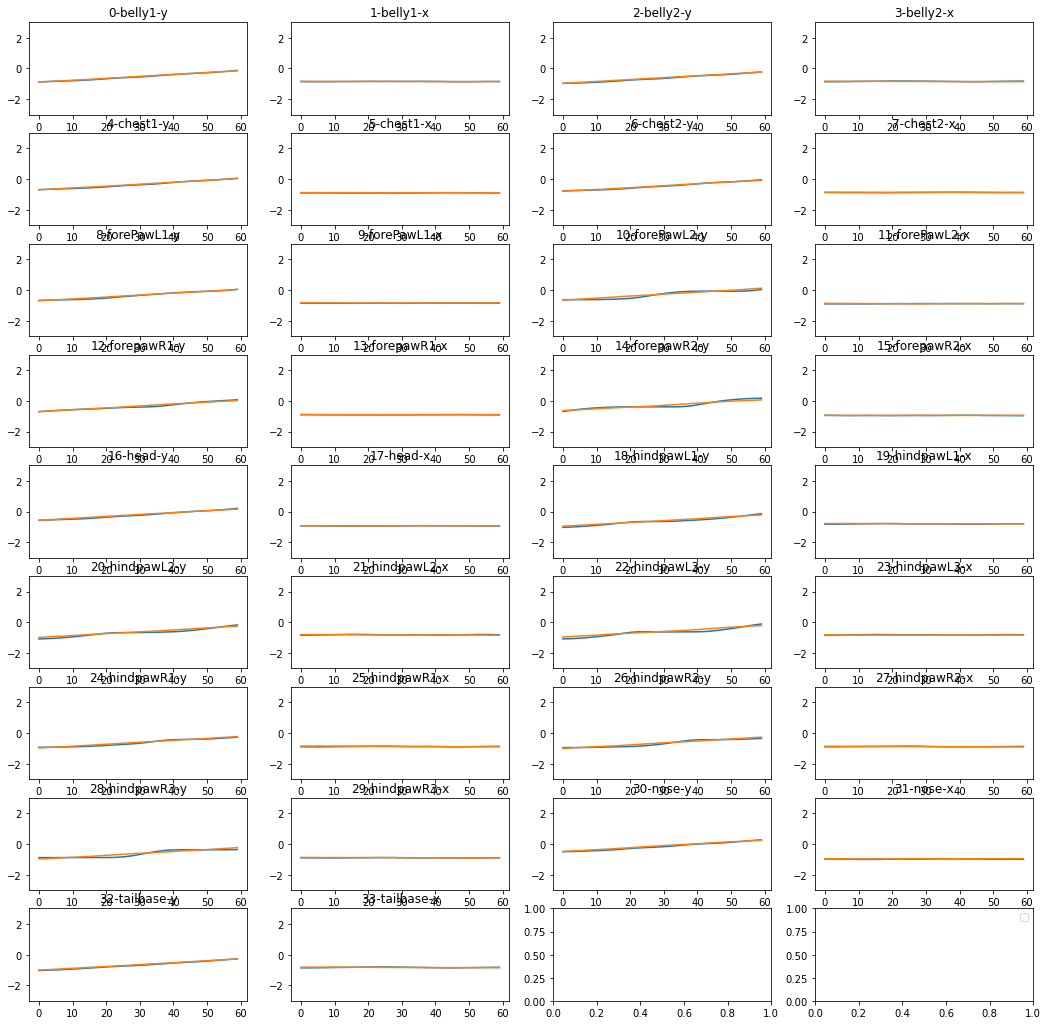

In [6]:
body_parts = dm.data_frames[0].columns.levels[0]
def compare_plot(x, y):
    x = x.reshape(-1, n_parts*2)
    y = y.reshape(-1, n_parts*2)
    fig, axes = plt.subplots(ncols=4, nrows=n_parts//2+1, figsize=(18, 18))
    for i in range(n_parts//2+1):
        for j in range(4):
            idx = 4*i + j
            if idx >= x.shape[1]: break
            axes[i][j].plot(x[:,idx], label='orig')
            axes[i][j].plot(y[:,idx], label='recon')
            axes[i][j].set_title(f"{idx}-{body_parts[idx//2]}-{'x' if idx%2 else 'y'}")
            axes[i][j].set_ylim(-3, 3)
    plt.legend()

idx = 46242
with torch.no_grad():
    bx = torch.Tensor(dm.all_ds[idx])[None]
    out = model(bx)
compare_plot(bx[0].cpu().numpy(), out[0].cpu().numpy())